In [1]:
import numpy as np
import xarray as xr
import dask.array as da
from dask.distributed import Client, LocalCluster
import gc
import sys
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib as mpl

In [2]:
EARTH_RADIUS_KM = 6371.0
MAX_DIST_KM = 500
TIME_TOL_HOURS = 8
ALT_MIN, ALT_MAX = 0.5, 64.5
ALT_GRID = np.arange(ALT_MIN, ALT_MAX + 1, dtype=np.float32)
TIME_TOL = np.timedelta64(TIME_TOL_HOURS, 'h').astype('timedelta64[ns]')

CHUNK_SIZE_L = 50000
CHUNK_SIZE_S = 25000

In [3]:
def process_dataarray(da_o3):
    da_transposed = da_o3.transpose('time', 'altitude')
    
    n_time = da_transposed.sizes['time']
    n_alt = da_transposed.sizes['altitude']
    
    time_chunks = CHUNK_SIZE_L if n_time > 500000 else CHUNK_SIZE_S
    alt_chunks = min(32, n_alt)
    
    if isinstance(da_transposed.data, da.Array):
        da_transposed = da_transposed.chunk({'time': time_chunks, 'altitude': alt_chunks})
    else:
        da_transposed.data = da.from_array(da_transposed.data, 
                                          chunks=(time_chunks, alt_chunks))
    
    return da_transposed

def compute_diffs(o3L, o3S):
    """Vectorized relative and absolute difference computation"""
    sum_vals = o3L + o3S
    diff_vals = o3L - o3S
    return 200 * (diff_vals / sum_vals), diff_vals

def haversine_vectorized(lat1, lon1, lat2, lon2):
    """Vectorized Haversine distance calculation between points (in radians)"""
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return EARTH_RADIUS_KM * c

In [4]:
import OSIRIS.OSIRIS_helper as OSIRIS
import ACEFTS.ACEFTS_helper as ACE

KeyboardInterrupt: 

In [ ]:
daL = OSIRIS.get_vmr()
daS = ACE.get_vmr()

In [ ]:
daL = daL.sel(altitude=slice(ALT_MIN, ALT_MAX)).interp({"altitude": ALT_GRID})
daS = daS.sel(altitude=slice(ALT_MIN, ALT_MAX)).interp({"altitude": ALT_GRID})

daL = process_dataarray(daL)
daS = process_dataarray(daS)

assert np.array_equal(daL.altitude.values, ALT_GRID), "OSIRIS alt mismatch!"
assert np.array_equal(daS.altitude.values, ALT_GRID), "ACE-FTS alt mismatch!"

In [ ]:
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit='3GB',
    processes=False,
    dashboard_address=None
)
client = Client(cluster)


In [ ]:
o3L_arr = daL.values.astype(np.float32)
o3S_arr = daS.values.astype(np.float32)
tL = daL.time.values.astype('datetime64[ns]')
tS = daS.time.values.astype('datetime64[ns]')
latL = daL.latitude.values
lonL = daL.longitude.values
latS = daS.latitude.values
lonS = daS.longitude.values

tS_min = tS.min() - TIME_TOL
tS_max = tS.max() + TIME_TOL
time_mask = (tL >= tS_min) & (tL <= tS_max)
tL_filtered = tL[time_mask]
o3L_arr_filtered = o3L_arr[time_mask]
latL_filtered = latL[time_mask]
lonL_filtered = lonL[time_mask]

client.close()
cluster.close()
del o3L_arr, latL, lonL
gc.collect()

c:\Users\salla\anaconda3\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 65.50 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


60011

In [ ]:
tL_ns = tL_filtered.astype(np.int64)
tS_ns = tS.astype(np.int64)
TIME_TOL_ns = TIME_TOL.astype(np.int64)

PEARL_lat, PEARL_long = 80.05, -86.42

processed_pairs = 0
o3S_coincidences = []
o3L_coincidences = []
measurement_times = []
measurement_times_dt = []

time_bins = np.arange(tL_ns.min(), tL_ns.max() + 1, TIME_TOL_ns)
bin_indices = np.digitize(tL_ns, time_bins)

max_bin = len(time_bins) + 1
time_binned_arrays = [np.array([], dtype=np.int64) for _ in range(max_bin + 1)]

for bin_id in range(0, max_bin + 1):
    time_binned_arrays[bin_id] = np.where(bin_indices == bin_id)[0]

bin_offsets = np.arange(-1, 2)

for s_idx, (s_time, s_lat, s_lon) in enumerate(zip(tS_ns, latS, lonS)):
    if s_idx % 10000 == 0:
        print(f"Processing ACE-FTS point {s_idx}/{len(tS)}...")
    
    PEARL_lat = 80.05
    PEARL_long = -86.42
    PEARL_dist_S = haversine_vectorized(s_lat, s_lon, PEARL_lat, PEARL_long)
    if PEARL_dist_S > MAX_DIST_KM:
        continue

    center_bin = np.digitize(s_time, time_bins)
    bin_ids = center_bin + bin_offsets
    bin_ids = bin_ids[(bin_ids >= 1) & (bin_ids < max_bin)]

    candidate_indices = np.concatenate([time_binned_arrays[bin_id] for bin_id in bin_ids])
    if candidate_indices.size == 0:
        continue

    time_diffs = np.abs(tL_ns[candidate_indices] - s_time)
    time_mask = time_diffs <= TIME_TOL_ns

    if not np.any(time_mask):
        continue

    time_valid_indices = candidate_indices[time_mask]
    candidate_lats = latL_filtered[time_valid_indices]
    candidate_lons = lonL_filtered[time_valid_indices]
    
    dists = haversine_vectorized(s_lat, s_lon, candidate_lats, candidate_lons)
    PEARL_dists_L = haversine_vectorized(PEARL_lat, PEARL_long, candidate_lats, candidate_lons)
    dist_conditions = (PEARL_dists_L <= MAX_DIST_KM) & (dists <= MAX_DIST_KM)
    if not np.any(dist_conditions):
        continue

    time_valid_indices = time_valid_indices[dist_conditions]
    valid_dists = dists[dist_conditions]

    min_idx = np.argmin(valid_dists)
    min_dist = valid_dists[min_idx]

    if min_dist <= MAX_DIST_KM:
        best_L_idx = time_valid_indices[min_idx]
        o3L_coincidences.append(o3L_arr_filtered[best_L_idx])
        o3S_coincidences.append(o3S_arr[s_idx])
        processed_pairs += 1
        if processed_pairs % 1000 == 0:
            print(f"Found {processed_pairs} pairs at ACE-FTS point {s_idx}...")

        measurement_times.append(tS_ns[s_idx])
        measurement_times_dt.append(tS[s_idx])

o3S_coincidences = np.vstack(o3S_coincidences)
o3L_coincidences = np.vstack(o3L_coincidences)
print(f"Total coincidences found: {processed_pairs}")

Processing ACE-FTS point 0/132071...
Processing ACE-FTS point 10000/132071...
Processing ACE-FTS point 20000/132071...
Processing ACE-FTS point 30000/132071...
Processing ACE-FTS point 40000/132071...
Processing ACE-FTS point 50000/132071...
Processing ACE-FTS point 60000/132071...
Processing ACE-FTS point 70000/132071...
Processing ACE-FTS point 80000/132071...
Processing ACE-FTS point 90000/132071...
Processing ACE-FTS point 100000/132071...
Processing ACE-FTS point 110000/132071...
Processing ACE-FTS point 120000/132071...
Processing ACE-FTS point 130000/132071...
Total coincidences found: 536


In [ ]:
seasonal_months = {"DJF": [12,1,2], "MAM": [3,4,5], "JJA": [6,7,8], "SON": [9,10,11]}

pd_measurement_times = pd.to_datetime(measurement_times_dt)
seasonal_measurement_idx = {season: np.where(pd_measurement_times.month.isin(months))[0]
                            for season, months in seasonal_months.items()}

In [ ]:
o3S_seasonal_coincidences = {season: o3S_coincidences[seasonal_measurement_idx[season]]
                             for season in seasonal_measurement_idx}

o3L_seasonal_coincidences = {season: o3L_coincidences[seasonal_measurement_idx[season]]
                             for season in seasonal_measurement_idx}

o3S_seasonal_coincidences_times = {season: np.array(measurement_times)[seasonal_measurement_idx[season]]
                                   for season in seasonal_measurement_idx}

n_seasonal_coincidences = {season: o3S_seasonal_coincidences[season].shape[0]
                           for season in o3S_seasonal_coincidences}

no_seasonal_coincidences = [season for season, n in n_seasonal_coincidences.items() if n == 0]

In [ ]:
max_time = max(measurement_times)
min_time = min(measurement_times)

vmin = np.percentile(measurement_times, 2.5)
vmax = np.percentile(measurement_times, 97.5)

vmin = max(vmin - 0.025 * (vmax - vmin), min_time)
vmax = min(vmax + 0.025 * (vmax-vmin), max_time)

normalizer = plt.Normalize(vmin=vmin, vmax=vmax, clip=True)

num_ticks = 7
tick_locations = np.linspace(vmin, vmax, num=num_ticks)
tick_dates = tick_locations.astype('datetime64[ns]')
tick_labels = list(np.datetime_as_string(tick_dates, unit='D'))
               
cmap = plt.get_cmap('nipy_spectral')
mappable = mpl.cm.ScalarMappable(norm=normalizer, cmap=cmap)

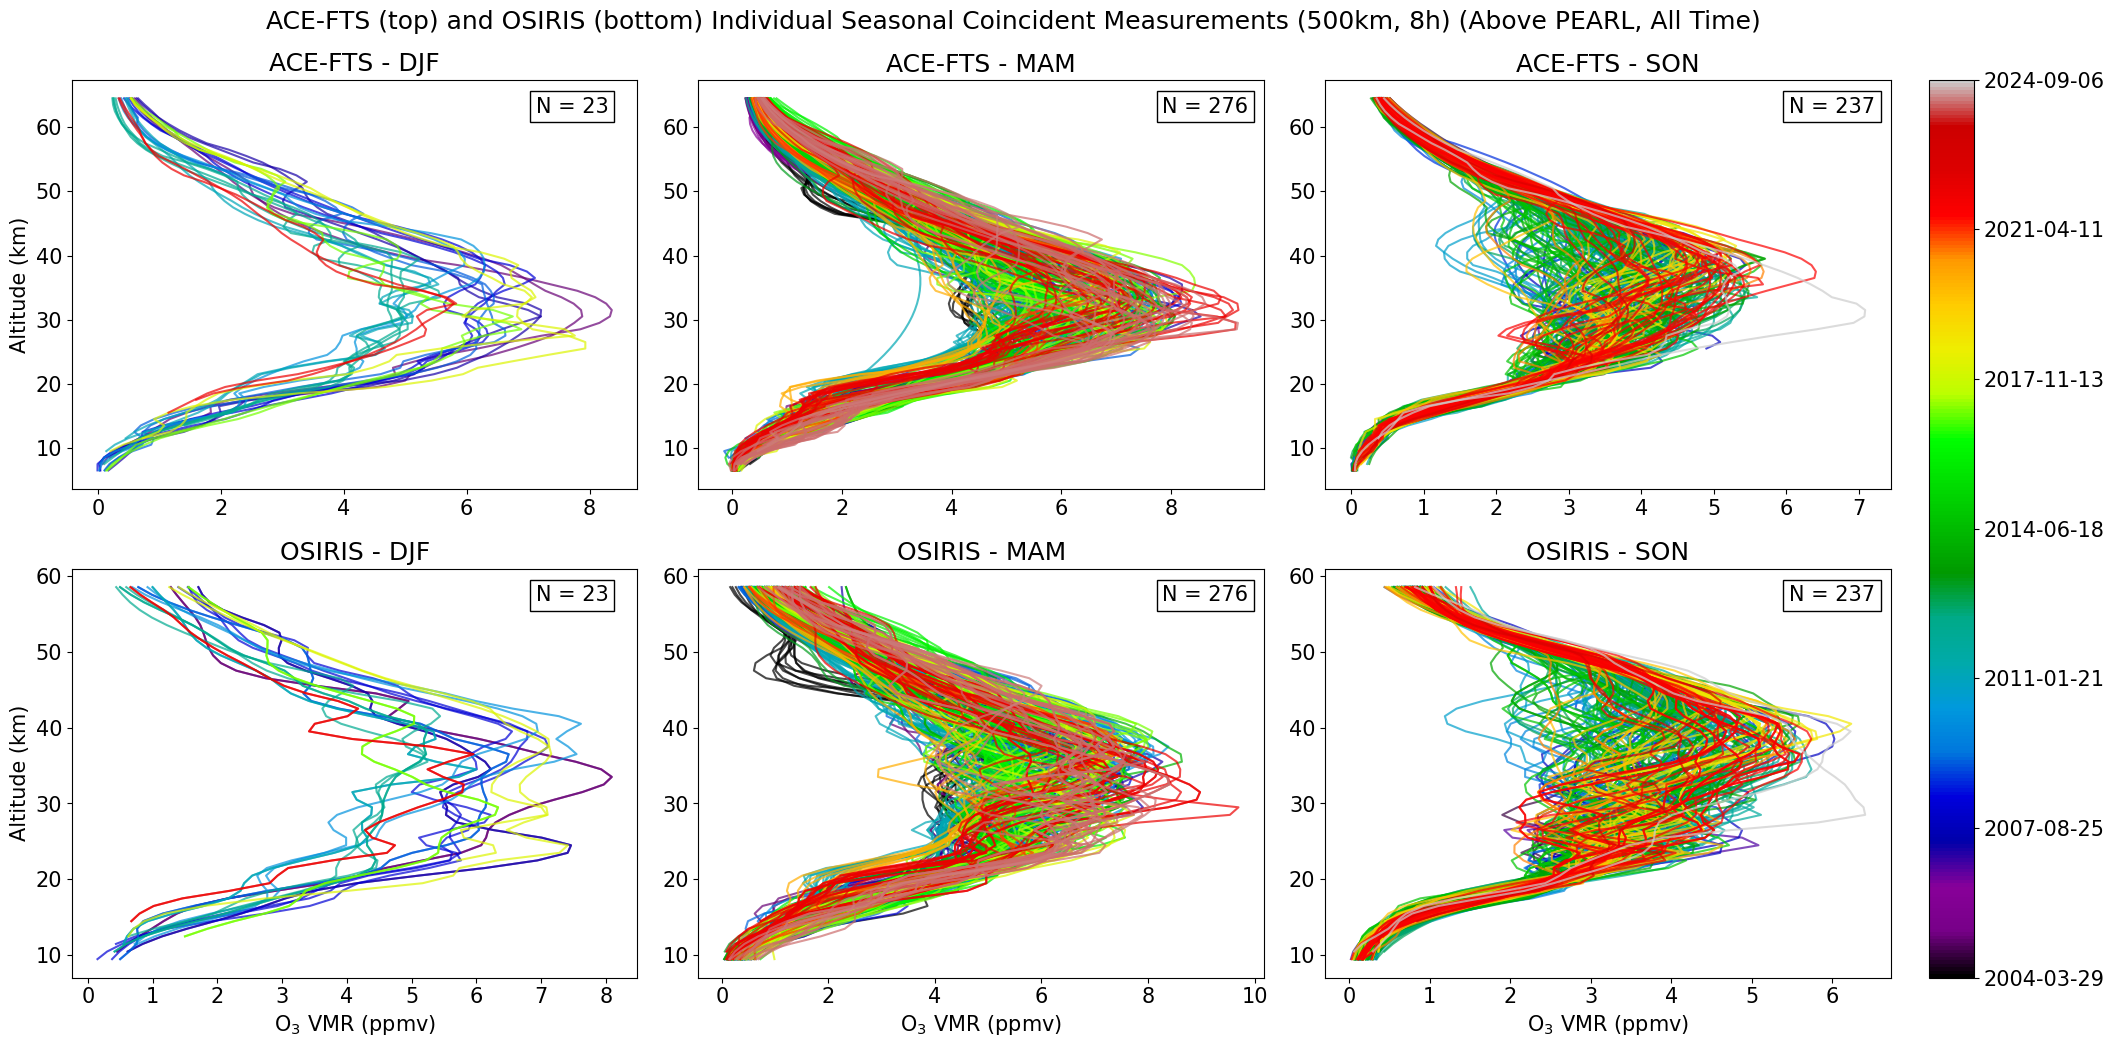

In [ ]:
fig, axes = plt.subplots(2, len(n_seasonal_coincidences) - len(no_seasonal_coincidences), figsize=(20, 10))
seasons = list(seasonal_months.keys())

for season in no_seasonal_coincidences:
    seasons.remove(season)

for i, season in enumerate(seasons):
    top_ax = axes[0, i]
    bottom_ax = axes[1, i]
    season_times = o3S_seasonal_coincidences_times[season]
    n_season_coincidences = n_seasonal_coincidences[season]

    for j, o3S_season_coincidence in enumerate(o3S_seasonal_coincidences[season]):
        S_values = o3S_seasonal_coincidences[season][j, :] * 10**6
        
        color = cmap(normalizer(season_times[j]))

        top_ax.plot(
            S_values,
            ALT_GRID,
            color=color,
            alpha=0.7
        )
        top_ax.set_title(f"ACE-FTS - {season}")

    
        A_values = o3L_seasonal_coincidences[season][j, :] * 10**6
        
        bottom_ax.plot( 
            A_values,
            ALT_GRID,
            color=color,
            alpha=0.7
        )
        bottom_ax.set_title(f"OSIRIS - {season}")
    
    top_ax.text(0.820, 0.920, f"N = {n_season_coincidences}", fontsize=15, transform=top_ax.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))
    bottom_ax.text(0.820, 0.920, f"N = {n_season_coincidences}", fontsize=15, transform=bottom_ax.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

fig.tight_layout()

cbar = fig.colorbar(
    mappable,
    ax = axes,
    orientation='vertical',
    fraction=0.03,
    pad=0.02)

cbar.set_ticks(tick_locations)
cbar.ax.set_yticklabels(tick_labels)

axes[1, 0].set_xlabel("O$_3$ VMR (ppmv)")
axes[1, 1].set_xlabel("O$_3$ VMR (ppmv)")
axes[1, 2].set_xlabel("O$_3$ VMR (ppmv)")
axes[0, 0].set_ylabel("Altitude (km)")
axes[1, 0].set_ylabel("Altitude (km)")

plt.suptitle("ACE-FTS (top) and OSIRIS (bottom) Individual Seasonal Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (Above PEARL, All Time)", y = 1.02)

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

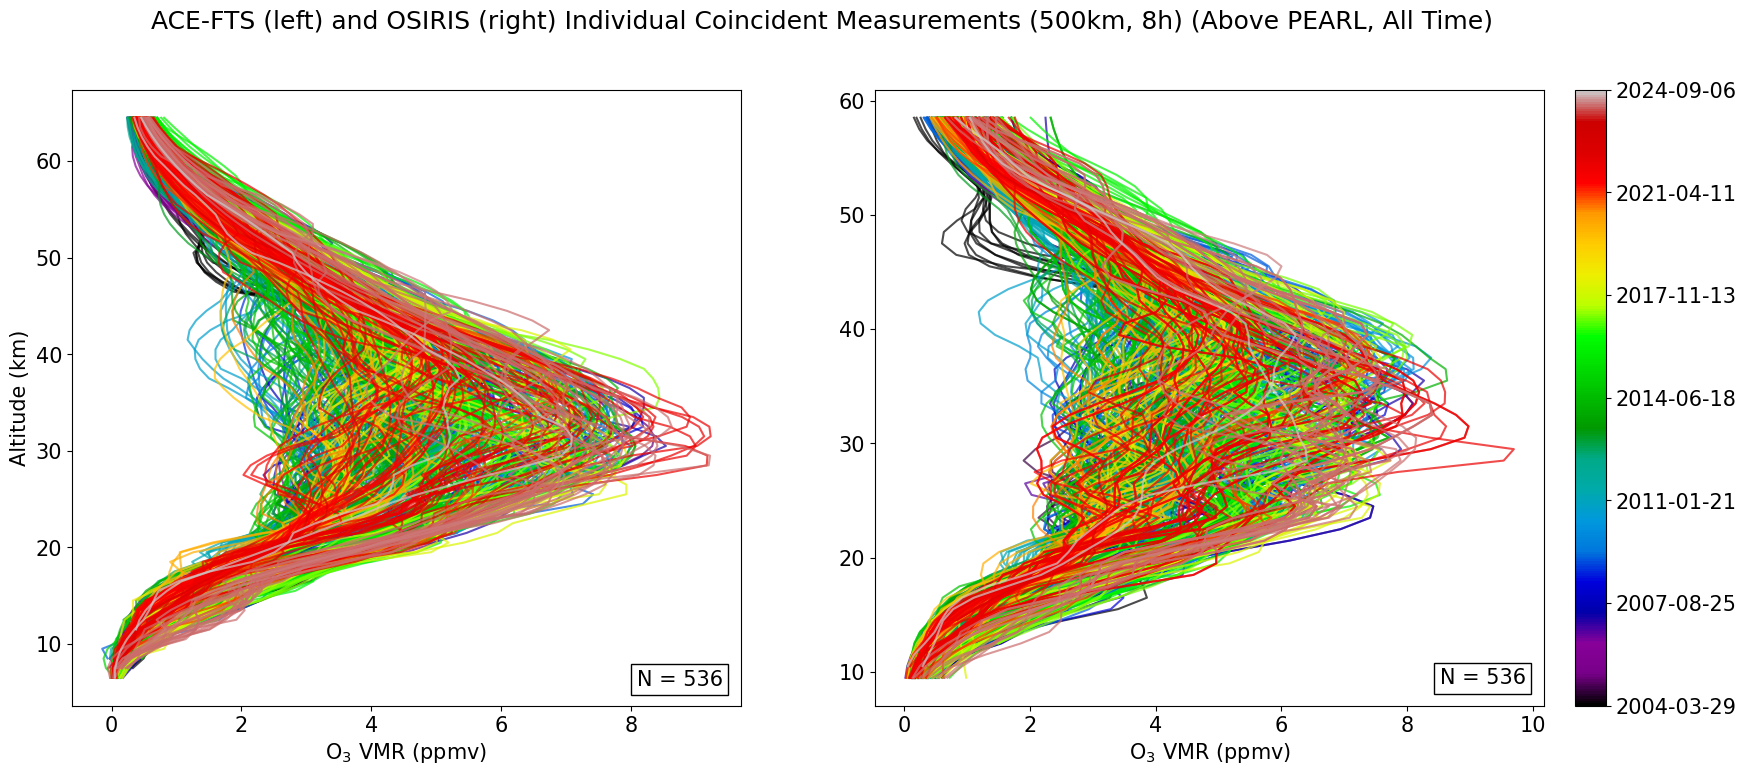

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

n_coincidences = o3S_coincidences.shape[0]
mappable = mpl.cm.ScalarMappable(norm=normalizer, cmap=cmap)

for coincidence_idx in range(n_coincidences):
    S_values = o3S_coincidences[coincidence_idx, :] * 10**6
    
    L_values = o3L_coincidences[coincidence_idx, :] * 10**6
    
    color = cmap(normalizer(measurement_times[coincidence_idx]))
    axes[0].plot(
        S_values,
        ALT_GRID,
        color=color,
        alpha=0.7
    )
    
    axes[1].plot(
        L_values,
        ALT_GRID,
        color=color,
        alpha=0.7
    )

axes[0].set_xlabel("O$_3$ VMR (ppmv)")
axes[1].set_xlabel("O$_3$ VMR (ppmv)")
axes[0].set_ylabel("Altitude (km)")

cbar = fig.colorbar(
    mappable,
    ax=axes,
    orientation='vertical',
    fraction=0.03,
    pad=0.02
)

cbar.set_ticks(tick_locations)
cbar.ax.set_yticklabels(tick_labels)

plt.suptitle("ACE-FTS (left) and OSIRIS (right) Individual Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (Above PEARL, All Time)")

axes[0].text(0.844, 0.0325, f"N = {len(o3L_coincidences)}", fontsize=15, transform=axes[0].transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))
axes[1].text(0.844, 0.035, f"N = {len(o3L_coincidences)}", fontsize=15, transform=axes[1].transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

In [ ]:
rel, abs = compute_diffs(o3L_coincidences, o3S_coincidences)

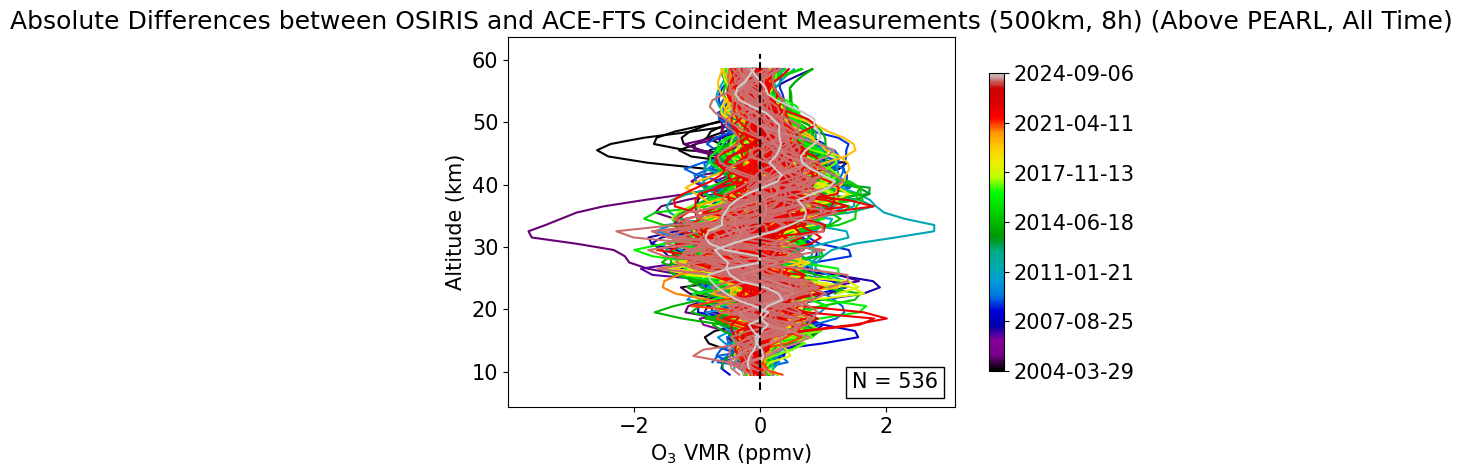

In [ ]:
for i in range(n_coincidences):
    plt.plot(abs[i,:] * 10**6, ALT_GRID, color = cmap(normalizer(measurement_times[i])))

mappable = mpl.cm.ScalarMappable(norm=normalizer, cmap=cmap)
plt.plot([0, 0], list(plt.ylim()), color = "black", linestyle = "--")
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Absolute Differences between OSIRIS and ACE-FTS Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (Above PEARL, All Time)")

fig = plt.gcf()
axes = plt.gca()

cbar = fig.colorbar(
    mappable,
    ax=axes,
    orientation='vertical',
    fraction=0.03,
    pad=0.07
)

cbar.set_ticks(tick_locations)
cbar.ax.set_yticklabels(tick_labels)

axes.text(0.770, 0.050, f"N = {len(o3L_coincidences)}", fontsize=15, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [ ]:
rel_diffs = np.nanmean(rel, axis = 0)
rel_std = np.nanstd(rel, axis = 0)
rel_err = rel_std / (rel.shape[0] ** 0.5)

abs_diffs = np.nanmean(abs, axis = 0)
abs_std = np.nanstd(abs, axis = 0)
abs_err = np.nanstd(abs, axis = 0) / (abs.shape[0] ** 0.5)

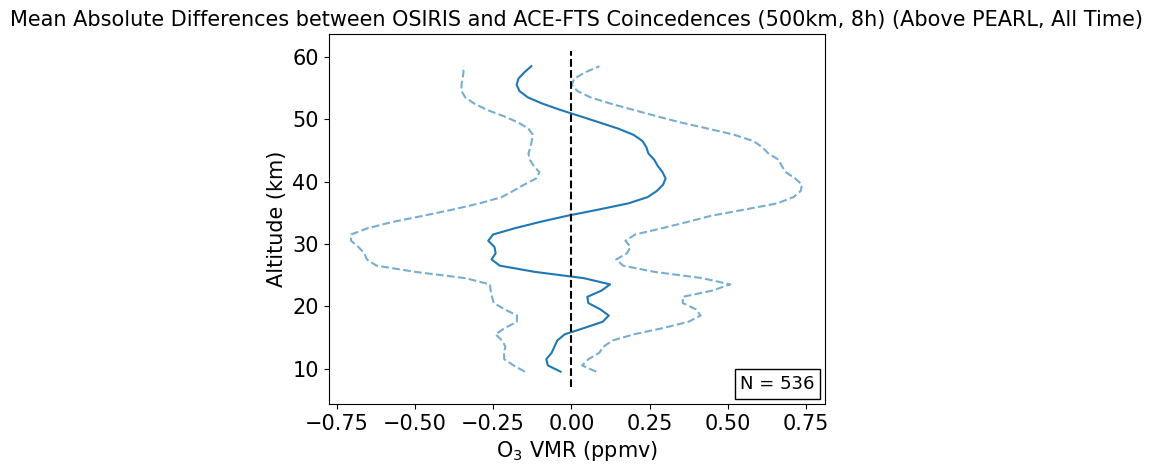

In [ ]:
plt.plot(abs_diffs * 10**6, ALT_GRID)
plt.plot((abs_diffs - abs_std) * 10**6, ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6)
plt.plot((abs_diffs + abs_std) * 10**6, ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6)
plt.plot([0, 0], list(plt.ylim()), color = "black", linestyle = "--")
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Mean Absolute Differences between OSIRIS and ACE-FTS Coincedences" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (Above PEARL, All Time)", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

axes.text(0.830, 0.04, f"N = {len(o3L_coincidences)}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title + "(std)", bbox_inches="tight")

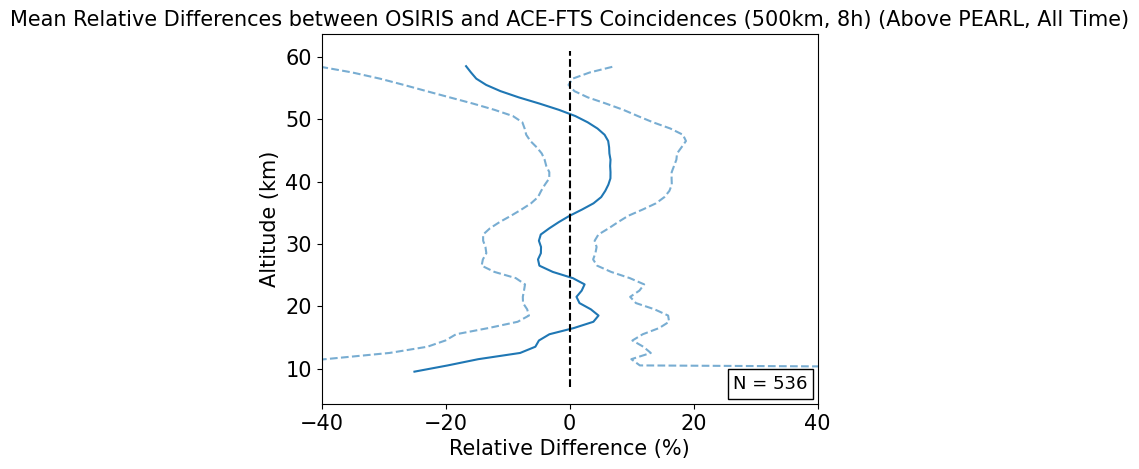

In [ ]:
plt.plot(rel_diffs, ALT_GRID)
plt.plot((rel_diffs - rel_std), ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6)
plt.plot((rel_diffs + rel_std), ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6)
plt.plot([0, 0], list(plt.ylim()), color = "black", linestyle = "--")
plt.xlim(-40,40)
plt.xlabel("Relative" + " Difference (%)")
plt.ylabel("Altitude (km)")
plt.title("Mean Relative Differences between OSIRIS and ACE-FTS Coincidences" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (Above PEARL, All Time)", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

axes.text(0.830, 0.04, f"N = {len(o3L_coincidences)}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title + "(std)", bbox_inches="tight")

In [ ]:
rel_seasonal = {season: compute_diffs(o3L_seasonal_coincidences[season], o3S_seasonal_coincidences[season])[0] for season in seasonal_months}

abs_seasonal = {season: compute_diffs(o3L_seasonal_coincidences[season], o3S_seasonal_coincidences[season])[1] for season in seasonal_months}

rel_diffs_seasonal = {season: np.nanmean(rel_season, axis = 0) for season, rel_season in rel_seasonal.items()}

rel_std_seasonal = {season: np.nanstd(rel_season, axis = 0) for season, rel_season in rel_seasonal.items()}

abs_diffs_seasonal = {season: np.nanmean(abs_season, axis = 0) for season, abs_season in abs_seasonal.items()}

abs_std_seasonal = {season: np.nanstd(abs_season, axis = 0) for season, abs_season in abs_seasonal.items()}

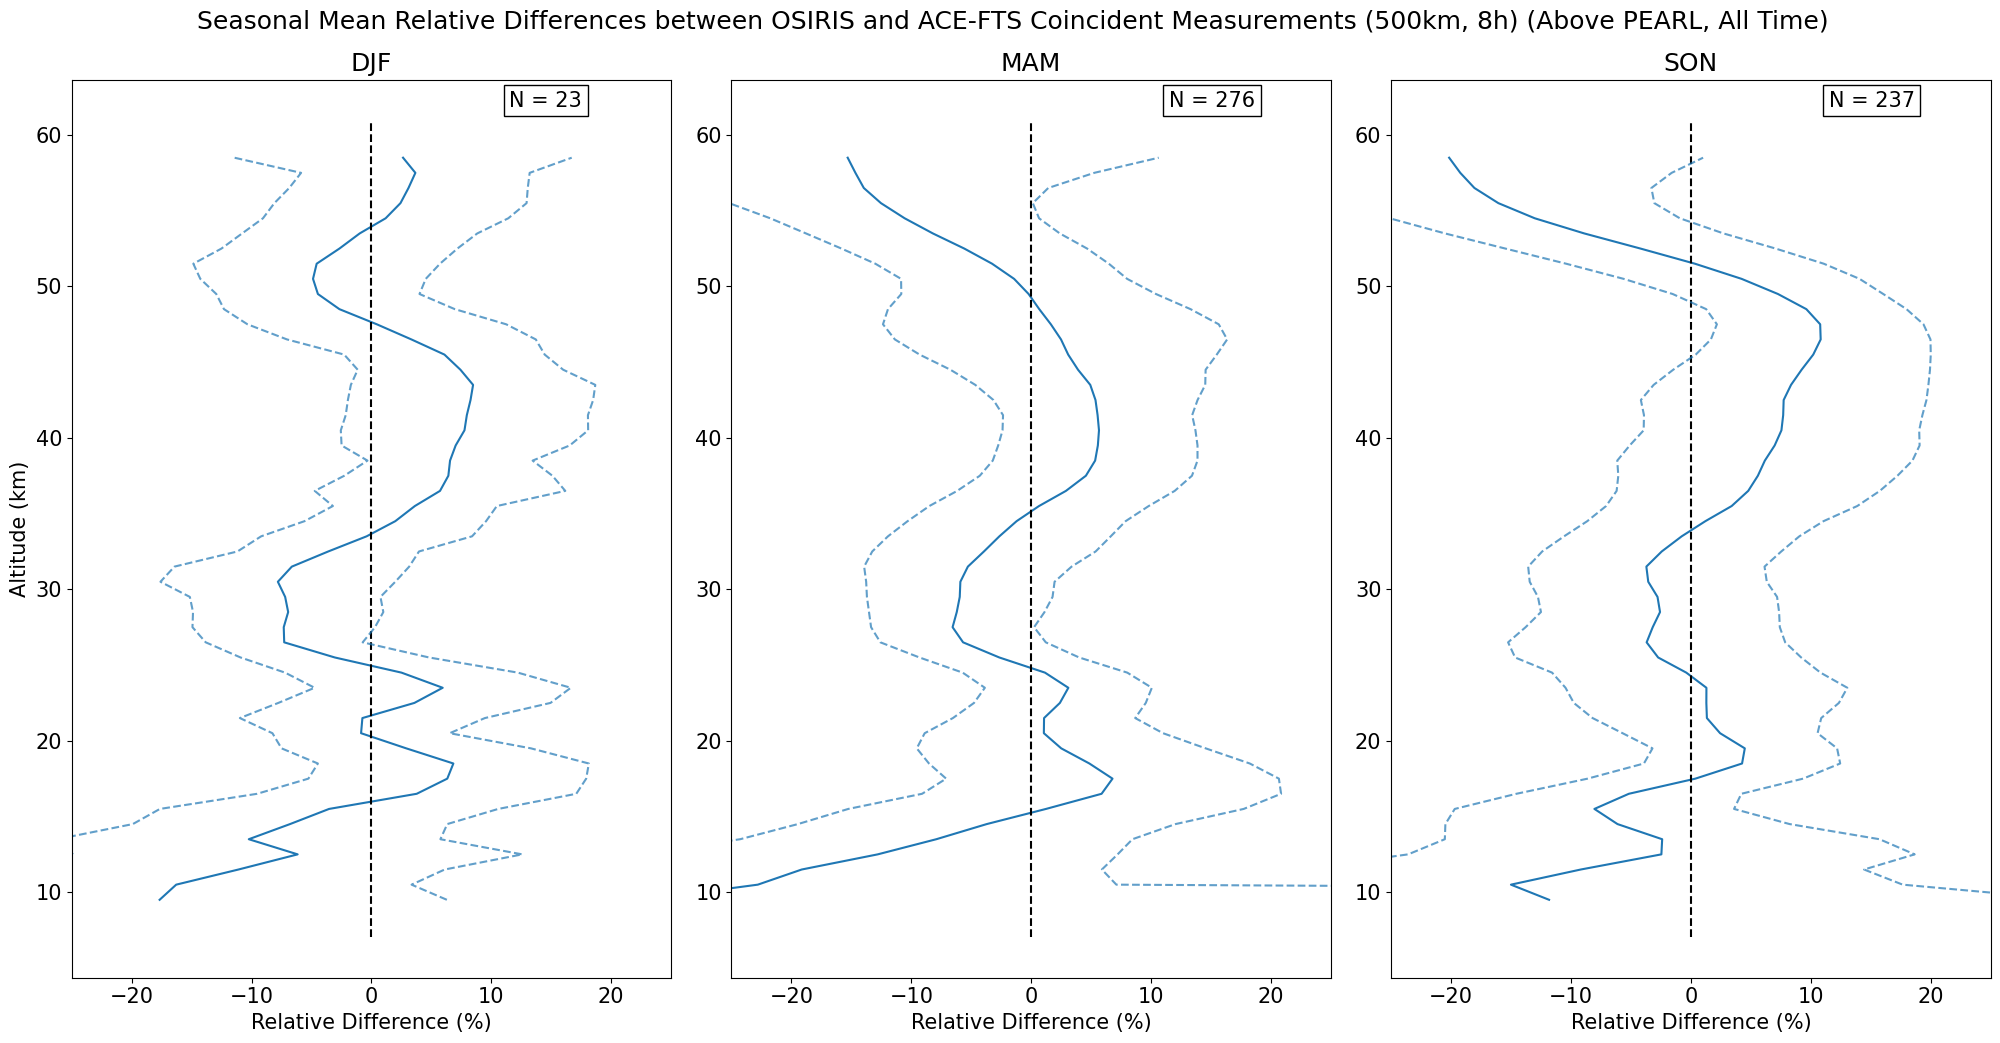

In [ ]:
fig, axes = plt.subplots(1, len(n_seasonal_coincidences) - len(no_seasonal_coincidences), figsize=(20, 10))
seasons = list(seasonal_months.keys())

for season in no_seasonal_coincidences:
    seasons.remove(season)

for i, season in enumerate(seasons):
    top_ax = axes[i]
    n_season_coincidences = n_seasonal_coincidences[season]

    top_ax.plot(
        rel_diffs_seasonal[season],
        ALT_GRID
    )
    top_ax.set_title(f"{season}")
    
    top_ax.plot([0, 0], list(top_ax.get_ylim()), color = "black", linestyle = "--")

    top_ax.plot(
        rel_diffs_seasonal[season] - rel_std_seasonal[season],
        ALT_GRID,
        alpha=0.7,
        color = "C0",
        linestyle = "dashed"
    )

    top_ax.plot(
        rel_diffs_seasonal[season] + rel_std_seasonal[season],
        ALT_GRID,
        alpha=0.7,
        color = "C0",
        linestyle = "dashed"
    )

    top_ax.text(0.730, 0.970, f"N = {n_season_coincidences}", fontsize=15, transform=top_ax.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

fig.tight_layout()

for ax in axes:
    ax.set_xlabel("Relative Difference (%)")
    ax.set_xlim(-25,25)

axes[0].set_ylabel("Altitude (km)")

plt.suptitle("Seasonal Mean Relative Differences between OSIRIS and ACE-FTS Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (Above PEARL, All Time)", y = 1.02)

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

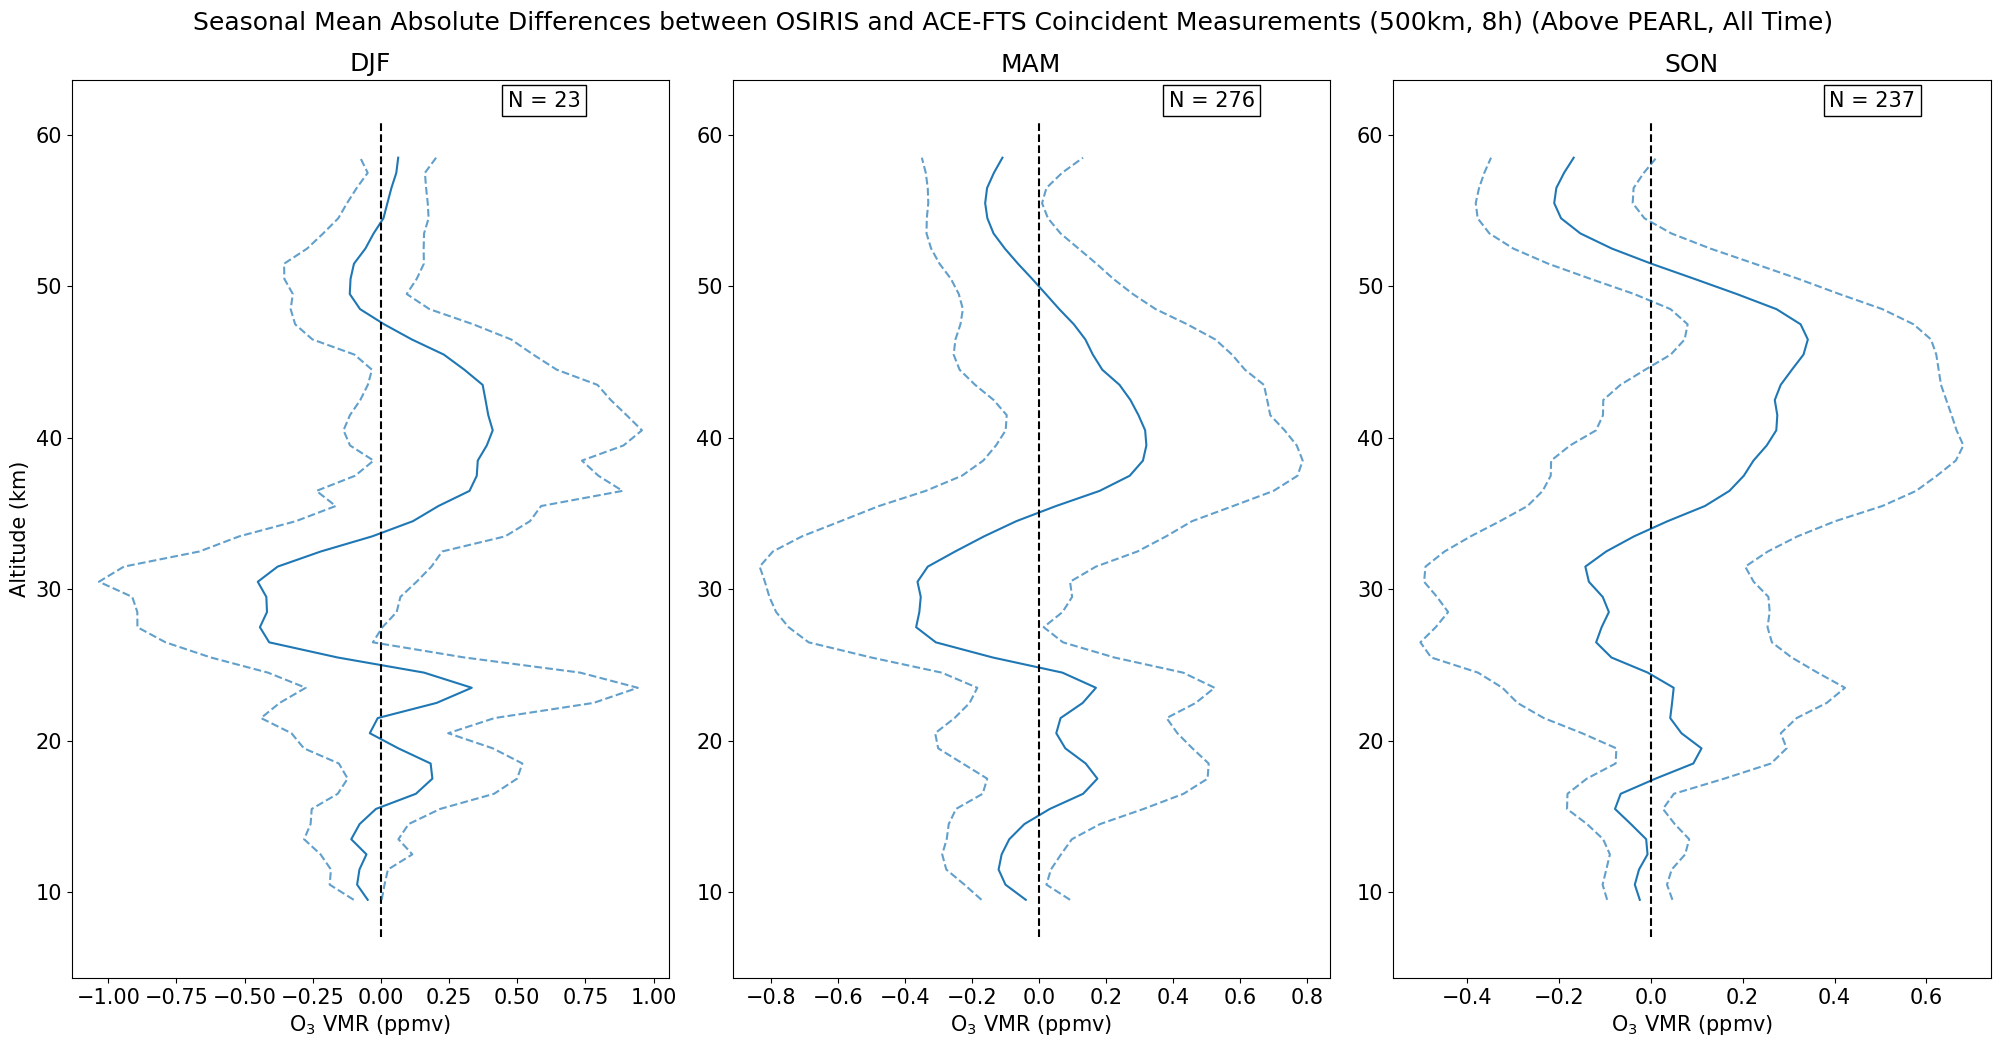

In [ ]:
fig, axes = plt.subplots(1, len(n_seasonal_coincidences) - len(no_seasonal_coincidences), figsize=(20, 10))
seasons = list(seasonal_months.keys())

for season in no_seasonal_coincidences:
    seasons.remove(season)

for i, season in enumerate(seasons):
    top_ax = axes[i]
    n_season_coincidences = n_seasonal_coincidences[season]

    top_ax.plot(
        (abs_diffs_seasonal[season]) * 10**6,
        ALT_GRID
    )
    top_ax.set_title(f"{season}")
    
    top_ax.plot([0, 0], list(top_ax.get_ylim()), color = "black", linestyle = "--")

    top_ax.plot(
        (abs_diffs_seasonal[season] - abs_std_seasonal[season]) * 10**6,
        ALT_GRID,
        alpha=0.7,
        color = "C0",
        linestyle = "dashed"
    )

    top_ax.plot(
        (abs_diffs_seasonal[season] + abs_std_seasonal[season]) * 10**6,
        ALT_GRID,
        alpha=0.7,
        color = "C0",
        linestyle = "dashed"
    )

    top_ax.text(0.730, 0.970, f"N = {n_season_coincidences}", fontsize=15, transform=top_ax.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

fig.tight_layout()

for ax in axes:
    ax.set_xlabel("O$_3$ VMR (ppmv)")

axes[0].set_ylabel("Altitude (km)")

plt.suptitle("Seasonal Mean Absolute Differences between OSIRIS and ACE-FTS Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (Above PEARL, All Time)", y = 1.02)

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

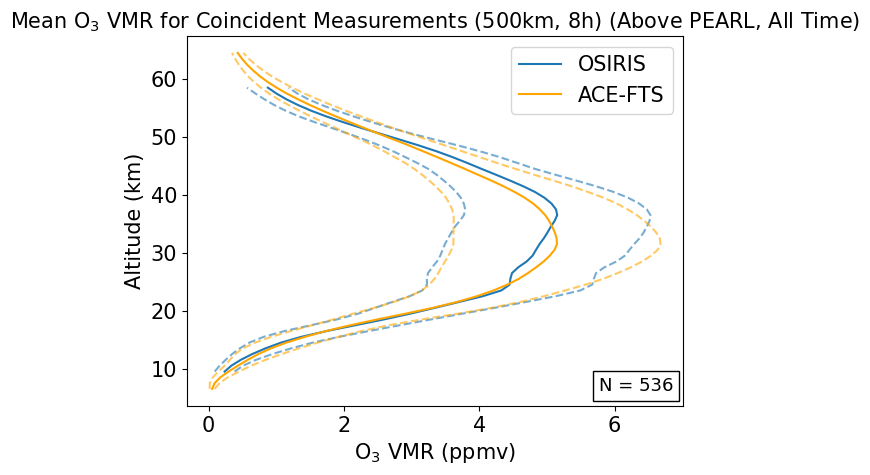

In [ ]:
std_L = np.nanstd(o3L_coincidences, axis = 0)
std_S = np.nanstd(o3S_coincidences, axis = 0)
mean_L = np.nanmean(o3L_coincidences, axis = 0)
mean_S = np.nanmean(o3S_coincidences, axis = 0)


plt.plot(mean_L * 10**6, ALT_GRID, label = "OSIRIS")
plt.plot((mean_L - std_L) * 10**6, ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6)
plt.plot((mean_L + std_L) * 10**6, ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6)

plt.plot(mean_S * 10**6, ALT_GRID, label = "ACE-FTS", color = "orange")
plt.plot((mean_S + std_S) * 10**6, ALT_GRID, color = "orange", linestyle = "dashed",  alpha = 0.6)
plt.plot((mean_S - std_S) * 10**6, ALT_GRID, color = "orange", linestyle = "dashed",  alpha = 0.6)

plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Mean O$_3$ VMR for Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (Above PEARL, All Time)", fontdict = {'fontsize': 15})
plt.legend()

fig = plt.gcf()
axes = plt.gca()

axes.text(0.830, 0.04, f"N = {len(o3L_coincidences)}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title + "(OSIRIS and ACE-FTS)", bbox_inches="tight")

In [ ]:
o3L_std = np.nanstd(o3L_coincidences, axis = 0)[None, :]
o3S_std = np.nanstd(o3S_coincidences, axis = 0)[None, :]
o3L_mean = np.nanmean(o3L_coincidences, axis = 0)[None, :]
o3S_mean = np.nanmean(o3S_coincidences, axis = 0)[None, :]

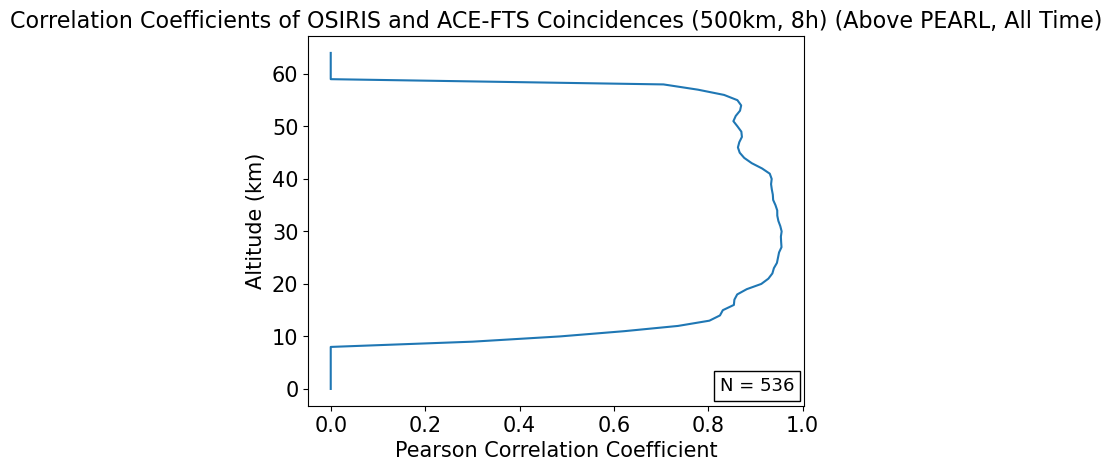

In [ ]:
summing = np.nansum(((o3L_coincidences - o3L_mean) / o3L_std) * ((o3S_coincidences - o3S_mean) / o3S_std), axis = 0) 

plt.plot(summing / (o3L_coincidences.shape[0] - 1), np.arange(len(summing)))
plt.ylabel("Altitude (km)")
plt.xlabel("Pearson Correlation Coefficient")
plt.title("Correlation Coefficients of OSIRIS and ACE-FTS Coincidences" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (Above PEARL, All Time)", fontdict = {"fontsize": 16})

fig = plt.gcf()
axes = plt.gca()

axes.text(0.830, 0.04, f"N = {len(o3L_coincidences)}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [ ]:
# fig = pcm_monthly.fig
# title = fig._suptitle.get_text()
# fig.savefig(title, bbox_inches="tight")

# fig = plt.gcf()
# axes = plt.gca()

# title = axes.get_title()
# fig.savefig(title, bbox_inches="tight")